In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from torchvision import datasets, transforms
from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

from IPython.core.debugger import set_trace

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x

In [4]:
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081
    

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()

Sequential(
  (0): Normalize()
  (1): Net(
    (fc): Linear(in_features=784, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=10, bias=True)
  )
)

In [7]:
# Copied from ex3

def fgsm(model, x, target, eps, targeted=True, clip_min=None, clip_max=None, **kwargs):
    """Internal process for all FGSM and PGD attacks. """    
    # create a copy
    x_tensor = x.clone().detach_()
    # enable gradient
    x_tensor.requires_grad_()
    # convert input target from integer into tensor    
    try:
        target = torch.tensor([target])
    except ValueError:
        # Should alreayd be a tensor than.
        pass
    
    # run the net on our target
    net_output = model(x_tensor)
    
    # calculate loss with respect to target label
    # for targeted FGSM this is NOT the true label
    # for untargeted FGSM this is the true label
    criterion = nn.CrossEntropyLoss()
    loss = criterion(net_output, target)

    # take the gradient of the loss
    model.zero_grad() # zero the buffer
    loss.backward() # backpropagate
    grad = x_tensor.grad
    grad_sign = torch.sign(grad)
    
    # attack
    if targeted:
        x_perturbed = x_tensor - eps * grad_sign
    else:
        x_perturbed = x_tensor + eps * grad_sign
    
    # clip the ouput back to the image domain, for MNIST it is [0,1]
    if (clip_min is not None) or (clip_max is not None):
        x_perturbed.clamp_(min=clip_min, max=clip_max) # Inplace clamping of pytorch
    return x_perturbed


def fgsm_targeted(model, x, target, eps, clip_min=None, clip_max=None):
    """
    Targeted Fast Gradient Sign Method
    
    Args:
        model: Neural net
        x: Tensor of the given data
        target: Target label
        eps: Size of Perturbation

    Returns:
        Perturbated Tensor
    """
    
    return fgsm(model, x, target, eps, targeted=True, clip_min=None, clip_max=None)

def fgsm_untargeted(model, x, correct_label, eps, clip_min=None, clip_max=None):
    """
    Targeted Fast Gradient Sign Method
    
    Args:
        model: Neuralnet
        x: Tensor of the given data
        label: Correct label
        eps: Size of Perturbation

    Returns:
        Perturbated Tensor
    """
    return fgsm(model, x, correct_label, eps, targeted=False, clip_min=None, clip_max=None)

def pgd(model, x, target, k, eps, eps_step, targeted=True, clip_min=None, clip_max=None, random_start=False, **kwargs):
    """
    Projected gradient descent base function
    
    Args:
        model: Neuralnet
        x: Tensor of the given data
        target: Target label
        eps: Size of L_inf ball on which we will project down to.
        eps_step: Size of Perturbation used for the FGSM

    Returns:
        Perturbated Tensor
    """
    # Define the L_inf ball for the projection
    x_min = x - eps
    x_max = x + eps
    
    if random_start:
        x_rand = torch.rand_like(x)*2 - 1 # Random tensor, uniform dist in interval [-1,1]
        x += x_rand*eps
    
    # FGSM step
    for i in range(k):
        adv = fgsm(model, x, target, eps_step, targeted=targeted, clip_min=None, clip_max=None, **kwargs)
        
        # Project on L_inf ball 
        adv = torch.max(x_min, adv) # If adv is inside the L_inf ball
        adv = torch.min(x_max, adv) # If adv is outside the L_inf ball
        x = adv
    
    # clip the ouput back to the image domain, for MNIST it is [0,1]
    if (clip_min is not None) or (clip_max is not None):
        adv.clamp_(min=clip_min, max=clip_max) # Inplace clamping of pytorch
    return adv    
        
    
def pgd_targeted(model, x, target, k, eps, eps_step, clip_min=None, clip_max=None, **kwargs):
    return pgd(model, x, target, k, eps, eps_step, targeted=True, clip_min=None, clip_max=None, **kwargs)

def pgd_untargeted(model, x, correct_label, k, eps, eps_step, clip_min=None, clip_max=None, **kwargs):
    x_adv = pgd(model, x, correct_label, k, eps, eps_step, targeted=False, clip_min=None, clip_max=None, **kwargs)
    return x_adv

# Problem 1.1 and 1.3
Train Network with PGD defense and batches and plot histogram of training loss and the development of it during training.

In [8]:
def display_histogram(model, loss, x, y):
    model.eval()
    # generate a loss histogram
    hist_data = []
    num_hist_samples = 1000
    for l in range(num_hist_samples):
        xprime = pgd_untargeted(model, x, y, 10, 0.08, 0.05, random_start = True)
        xprime, yprime = xprime.to(device), y.to(device)
        out = model(xprime)
        batch_loss = loss(out, yprime)
        hist_data.append(batch_loss.item())
        
    plt.xlim(left=0, right=max(1,max(hist_data)))
    plt.yscale('log')
    plt.hist(hist_data, weights=np.ones_like(hist_data) * 1/ num_hist_samples)
    plt.xlabel('Loss value')
    plt.ylabel('log(frequency)')
    plt.show()
    model.train()

In [9]:
from PIL import Image

def show_image_from_tensor(tensor, mult=255):
    data = tensor.numpy()*255
    img = Image.fromarray(data)
    img.show()

In [10]:
def train_model(model, num_epochs=20, hist=False, defense=True):
    learning_rate = 0.0001

    opt = optim.Adam(params=model.parameters(), lr=learning_rate)

    ce_loss = torch.nn.CrossEntropyLoss()

    writer = SummaryWriter()
    tot_steps = 0
    
    for epoch in range(1,num_epochs+1):
        t1 = time.time()
        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            
            if hist and batch_idx == 0:
                # init x for histogram
                x_hist = x_batch[0, ...]
                y_hist = y_batch[0].unsqueeze(0)

            if hist and batch_idx % 200 == 0:
                display_histogram(model, ce_loss, x_hist, y_hist)

            if defense:
                # Perturbate x to generate adverserial set by PGD attack
                model.eval() # faster attack in evaluation mode
                x_batch = pgd_untargeted(model, x_batch, y_batch, 5, 0.08, 0.05)
                model.train() # switch back to training

            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            tot_steps += 1
            opt.zero_grad()
            logits = model(x_batch)
            batch_loss = ce_loss(logits, y_batch)
            batch_loss.backward()
            opt.step()
        
        if hist:
            print('Final histogram after full epoch:')
            display_histogram(model, ce_loss, x_hist, y_hist)

        tot_test, tot_acc = 0.0, 0.0
        model.eval()
        for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
            model.eval()
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            pred = torch.max(logits, dim=1)[1]
            acc = pred.eq(y_batch).sum().item()
            tot_acc += acc
            tot_test += x_batch.size()[0]
        t2 = time.time()
        model.train()

        print('Epoch %d: Accuracy %.5lf [%.2lf seconds]' % (epoch, tot_acc/tot_test, t2-t1))           

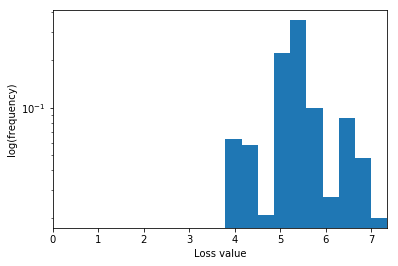

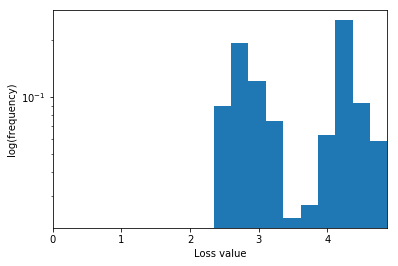

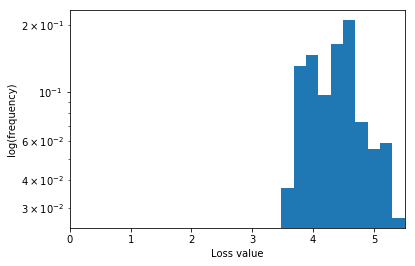

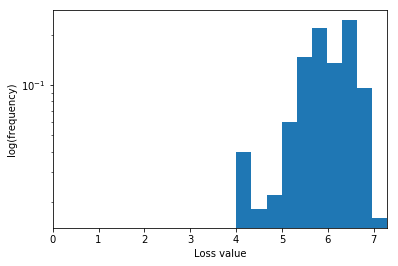

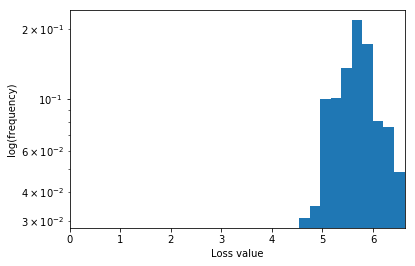

Final histogram after full epoch:


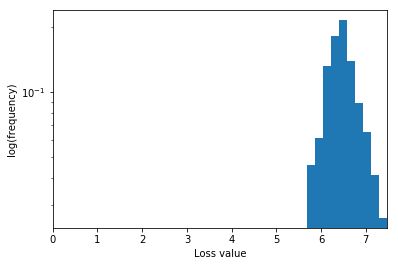

Epoch 1: Accuracy 0.88730 [70.02 seconds]


In [11]:
train_model(model, num_epochs=1, hist=True, defense=True)

# Results Interpretation
We can clearly see that the histogram gets narrower the more we train it with the pgd attacks.

# Problem 1.2
Compare accuracy of perturbed training images vs. non perturbed training images.

In [12]:
def get_n_correct(model, x_batch, y_batch):
    model.eval()
    logits = model(x_batch)
    model.train()
    pred = torch.max(logits, dim=1)[1]
    return  pred.eq(y_batch).sum().item()

def compare_accuracy(dataset_loader, model):
    n_samples = 1000

    n_tot_test, counter = 0.0, 0.0
    n_tot_correct = {'original':0, 'adv': 0}
    t1 = time.time()
    
    for batch_idx, (x_batch, y_batch) in enumerate(dataset_loader):
        counter += 1
        if x_batch.size()[0] + n_tot_test >= n_samples:
            n_rest = int(n_samples - n_tot_test)
            x_batch, y_batch = x_batch[:n_rest, ...], y_batch[:n_rest, ...]

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Original prediction
        n_tot_correct['original'] += get_n_correct(model, x_batch, y_batch)

        # Adverserial prediciton
        x_batch_adv = pgd_untargeted(model, x_batch, y_batch, 5, 0.08, 0.05)
        x_batch_adv = x_batch_adv.to(device)
        n_tot_correct['adv'] += get_n_correct(model, x_batch_adv, y_batch)

        # check if enough samples tested
        n_tot_test += x_batch.size()[0]    
        if n_tot_test >= n_samples:
            break

    t2 = time.time()
    tot_acc = {'original':0, 'adv': 0}
    tot_acc['original'] = n_tot_correct['original']/n_tot_test
    tot_acc['adv'] = n_tot_correct['adv']/n_tot_test

    print('Original Images Accuracy %.5lf [%.2f seconds]' % (tot_acc['original'], t2-t1))  
    print('Adverserial Images Accuracy %.5lf [%.2f seconds]' % (tot_acc['adv'], t2-t1))           

In [13]:
compare_accuracy(test_loader, model)

Original Images Accuracy 0.86600 [0.32 seconds]
Adverserial Images Accuracy 0.59900 [0.32 seconds]


In [14]:
compare_accuracy(train_loader, model)

Original Images Accuracy 0.87700 [0.30 seconds]
Adverserial Images Accuracy 0.63400 [0.30 seconds]


# Results Interpretation
by
We can see clearly that the accuracy for perturbed images goes down. Also by comparing the accuracy of adverserial examples for the trained and the test dataset we can see that for the test dataset the accuracy goes significantly down, which was expected.

Those results should be tested agains a model without PGD defense for further insides.